# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks

# Display sample data
daily_returns=df.pct_change()

avg_daily_spy = daily_returns.mean()['SPY']['close']
avg_daily_agg = daily_returns.mean()['AGG']['close']
avg_daily_agg

0.00021277231473764173

In [7]:
# Compute daily volatility

# Calculate volatility



std_spy = daily_returns.std()['SPY']['close']
std_agg = daily_returns.std()['AGG']['close']
std_agg

0.002089826211646555

In [8]:
# Save the last day's closing price
last_day=df.tail(1)
last_day

,AGG,SPY
,close,close
time,,
2019-12-31 00:00:00-05:00,112.37,321.92


In [9]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [10]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252*30


spy_last = df['SPY']['close'][-1]
agg_last = df['AGG']['close'][-1]


simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

for s in range(number_simulations):
    
    simulated_spy_prices = [spy_last]
    simulated_agg_prices = [agg_last]

    
    for i in range(number_records):
        
  
        sim_spy_result = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_spy,std_spy))
        sim_agg_result = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_agg,std_agg))
        
        
        simulated_spy_prices.append(sim_spy_result)
        simulated_agg_prices.append(sim_agg_result)
    
    simulated_price_df['SPY Prices']= pd.Series(simulated_spy_prices)
    simulated_price_df['AGG Prices']=pd.Series(simulated_agg_prices)
    
    
    
    simulated_daily_returns = simulated_price_df.pct_change()
    
    
    weights = [0.60, 0.40]
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[s] = (1+ portfolio_daily_returns.fillna(0)).cumprod()
    
    
    

    
portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,226.640601,183.013645,248.439395,266.549906,243.256943,193.970623,232.356573,365.582582,250.332474,270.407568,...,76.552297,264.237617,155.411639,244.125466,298.916293,336.863337,96.790248,217.572828,391.889121,101.934826
7557,226.358501,183.671480,249.086176,266.398180,241.567502,193.870304,231.197939,367.786650,249.053947,270.084122,...,75.939959,264.141594,155.158220,244.966009,298.846483,338.975713,97.712656,217.670540,395.634852,101.375060
7558,225.409380,183.751517,251.311869,266.615601,242.283891,194.152841,231.776757,368.377758,250.766427,269.200277,...,75.895997,265.537201,155.273325,245.868703,300.599696,337.955915,97.650009,216.306908,398.194448,100.915272
7559,225.106471,184.973766,252.193763,266.934848,242.216389,195.108231,231.795720,367.541031,251.152904,268.273273,...,76.370245,266.776351,154.040902,244.222613,301.180186,336.944712,98.674359,216.121532,399.598258,100.925960
7560,224.965889,185.695782,254.090683,267.175574,242.897877,195.557609,231.588919,365.930373,250.924391,268.263439,...,76.470507,268.161671,153.392527,246.305943,301.522993,337.249741,98.305461,214.568967,396.836102,101.121347


In [11]:
# Run the Monte Carlo Simulation


In [12]:
# Check that the simulation ran successfully


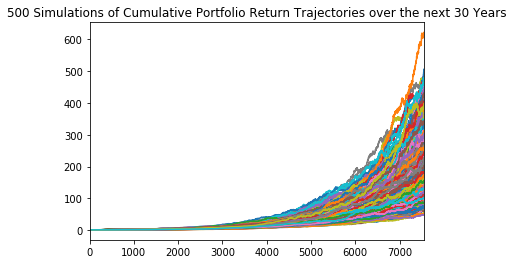

In [13]:
# Visualize the Simulation
plot_title = f"{s+1} Simulations of Cumulative Portfolio Return Trajectories over the next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
last_day = portfolio_cumulative_returns.iloc[-1,:]

last_day

0      224.965889
1      185.695782
2      254.090683
3      267.175574
4      242.897877
5      195.557609
6      231.588919
7      365.930373
8      250.924391
9      268.263439
10     120.334064
11     409.182673
12     194.579358
13     114.046357
14     167.001854
15     157.537844
16     136.315645
17     182.834017
18     462.690106
19     175.285413
20      60.662325
21     249.482456
22     167.546173
23     272.206875
24     214.706667
25     349.311326
26      96.351973
27     129.471217
28     201.170500
29     168.226657
          ...    
470    177.740511
471    129.330040
472    153.213865
473    117.682230
474    163.217496
475    215.816121
476    119.625588
477    199.781849
478    166.690071
479    342.904362
480    208.467867
481    174.606008
482     84.275455
483    184.430936
484    123.505852
485    202.829496
486    281.944619
487    221.572937
488    151.961261
489    129.306221
490     76.470507
491    268.161671
492    153.392527
493    246.305943
494    301

In [15]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
second_last_day = portfolio_cumulative_returns.iloc[5040,:]
second_last_day

0      29.893710
1      33.087827
2      25.848052
3      36.330787
4      40.662488
5      31.400544
6      32.385500
7      86.396391
8      32.307231
9      27.876544
10     18.951430
11     46.144027
12     25.723254
13     23.059270
14     29.587728
15     40.553001
16     22.126865
17     42.812082
18     64.557230
19     27.520215
20     18.485873
21     50.764255
22     25.208070
23     51.247605
24     45.145429
25     43.372507
26     17.303982
27     20.573860
28     35.137171
29     34.282880
         ...    
470    37.115812
471    24.885764
472    42.218508
473    23.329014
474    29.644039
475    29.363518
476    20.772754
477    27.387297
478    36.599234
479    47.619999
480    37.767367
481    33.911637
482    20.283614
483    35.200400
484    32.681870
485    29.230213
486    37.172898
487    53.916618
488    27.462629
489    41.553630
490    19.722616
491    37.570557
492    28.206719
493    41.077738
494    35.118158
495    48.686578
496    19.873180
497    38.3416

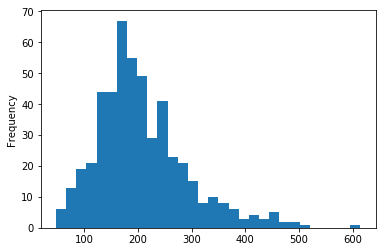

In [16]:
# Display the 90% confidence interval for the ending returns
last_day.plot(kind='hist', bins=30)

In [17]:
# Visualize the distribution of the ending returns
last_day.value_counts(bins=10)/ len(last_day)

(160.87, 217.584]     0.342
(104.157, 160.87]     0.218
(217.584, 274.297]    0.186
(274.297, 331.011]    0.088
(46.875, 104.157]     0.076
(331.011, 387.724]    0.048
(387.724, 444.437]    0.020
(444.437, 501.151]    0.018
(557.864, 614.578]    0.002
(501.151, 557.864]    0.002
Name: 7560, dtype: float64

In [18]:
confidence_interval = last_day.quantile(q=[.05,.95])
confidence_interval

0.05     94.350911
0.95    374.693262
Name: 7560, dtype: float64

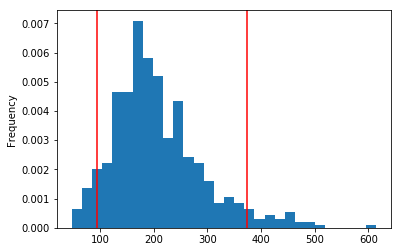

In [19]:
plt.figure();
last_day.plot(kind='hist', density=True, bins=30)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color = 'r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [20]:
# Compute cumulative returns
confidence_interval_10 = last_day.quantile(q=[.05])
confidence_interval_10
confidence_interval_90 = last_day.quantile(q=[.95])
confidence_interval_90
confidence_interval_50 = last_day.quantile(q=[.5])
confidence_interval_50

print(f"The Expected cumulative returns for the 10% is {confidence_interval_10.iloc[0]}")
print(f"The Expected cumulative returns for the 90% is {confidence_interval_90.iloc[0]}")

print(f"The Expected cumulative returns for the 50% is {confidence_interval_50.iloc[0]}")


The Expected cumulative returns for the 10% is 94.35091068255916
The Expected cumulative returns for the 90% is 374.69326161033706
The Expected cumulative returns for the 50% is 189.84383253943383


In [21]:
ci10 = confidence_interval_10.iloc[0]
ci50 = confidence_interval_50.iloc[0]
ci90 = confidence_interval_90.iloc[0]

print(ci10)
print(ci50)
print(ci90)

94.35091068255916
189.84383253943383
374.69326161033706


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [22]:
# Set initial investment

# Compute expected portfolio return
initial_investment = 20000

investment_pnl_10 = initial_investment * ci10
investment_pnl_90 = initial_investment * ci90
investment_pnl_50 = initial_investment * ci50

print(f"The Expected cumulative returns for the 10% is ${np.round(investment_pnl_10)}")
print(f"The Expected cumulative returns for the 50% is ${np.round(investment_pnl_50)}")

print(f"The Expected cumulative returns for the 90% is ${np.round(investment_pnl_90)}")

The Expected cumulative returns for the 10% is $1887018.0
The Expected cumulative returns for the 50% is $3796877.0
The Expected cumulative returns for the 90% is $7493865.0


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [23]:
# Set Plaid's projected income

# Calculate the 4% withdrawal for the ending return as retirement income

# Determine if the retirement income meets or exceeds the current projected income

withdrawal_rate = .04* investment_pnl_10

monthly_income = 500

if withdrawal_rate >= monthly_income:
    print('Account owner does not have a surplus and has short term liquidity needs. \n These needs should be met by a bond ladder or money market fund')


Account owner does not have a surplus and has short term liquidity needs. 
 These needs should be met by a bond ladder or money market fund


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [24]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
new_investment =initial_investment*1.5
new_investment

monthly_income=500

investment_pnl_10_new = new_investment * ci10

investment_pnl_10_new
second_withdrawal_rate = investment_pnl_10_new*.04

if second_withdrawal_rate >= monthly_income:
    print("Account owner is still needing cash on a monthly basis in excess of his monthly income. \n The income shortfall will need to come from his portfolio. ")

Account owner is still needing cash on a monthly basis in excess of his monthly income. 
 The income shortfall will need to come from his portfolio. 


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [25]:
# Compute projected returns

# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
